In [1]:
import os
import sys
sys.path.append('quality')
import pickle as pkl

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from quality.decay import env_qual, rms_qual
from quality.response import res_qual
from quality.tonality import frq_qual, ihd_qual
from librosa.effects import trim
from librosa.util import normalize

In [2]:
import torchaudio

def load(f):
    return torchaudio.load(f)[0][0].numpy()

full = os.listdir('../sampleset/full/')
bad = os.listdir('../sampleset/fake')

for i in range(0,len(full)):
    full[i] = "../sampleset/full/"+full[i]
for i in range(0,len(bad)):
    bad[i] = "../sampleset/fake/"+bad[i]

bad = list(map(load,bad))
full = list(map(load,full))

C:\Users\damen\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\damen\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
def compute_quals(sample, weights : list = [1,1,1,1,0]):
    """
    Quality = weights[0] * env_qual + weights[1] * res_qual + weights[2] * frq_qual + weights[3] * ihd_qual + weights[4] * lufs_qual
    """
    #preprocessing
    sample = normalize(trim(sample, top_db=50)[0])
    #qualities
    q0 = env_qual(sample)
    q1 = res_qual(sample)
    q2 = frq_qual(sample)
    q3 = ihd_qual(sample)
    q4 = rms_qual(sample)
    qual = weights[0] * q0 + weights[1] * q1 + weights[2] * q2 + weights[3] * q3 + weights[4] * q4
    return qual, (q0,q1,q2,q3,q4)

qual, qs = compute_quals(bad[0], [50,0.5,2,30,0.5])
print(qual,qs)

5.637690285292347 (0.0028370192075782247, 1.0976760087462931, 2.28155885601758, 0.0034690434, 0.5596246123313904)


In [4]:
#change weights here for easy use
w = [10, 0.5, 1, 2, 0.5]
x = np.array(0.5)
print(x)
print(float(x))

0.5
0.5


In [5]:
bad_quals = []
bad_qualqs = []
for b in bad:
    q, qs = compute_quals(b,w)
    bad_quals.append(q)
    bad_qualqs.append(qs)

print(bad_quals)
print(np.mean(bad_quals))

for i in range(0,len(bad_quals)):
        print(os.listdir('../sampleset/fake')[i], bad_quals[i], bad_qualqs[i])

[3.145517445454833, 2.426494709443232, 2.0804187426251586, 1.9153981747219155, 2.0793198058155156, 1.8981268523086645, 3.4241963736320544, 1.8660283143810172, 1.9260404095006822, 3.6692426941066483, 2.8482283123361833, 3.61123258957627, 2.187823274710191, 2.892659127928326]
2.569337630467192
Bill Copy Snare 6.wav 3.145517445454833 (0.0028370192075782247, 1.0976760087462931, 2.28155885601758, 0.0034690434, 0.5596246123313904)
birds.wav 2.426494709443232 (0.007611648732801436, 0.8444411443618514, 0, 0.7520639, 0.848059818148613)
birds2.wav 2.0804187426251586 (0.014239605821553728, 0.5444741474676196, 0, 0.6251208, 0.8310879468917847)
noise.wav 1.9153981747219155 (0.016884768647704614, 0.8311438206683195, 0.4011975582230572, 0.28101406, 0.7355058193206787)
noise_env_long.wav 2.0793198058155156 (0.01042948025079037, 0.8312471155985359, 0.406711079597814, 0.37501338, 0.8053272068500519)
noise_env_short.wav 1.8981268523086645 (0.009712523758612895, 0.8312809445320082, 1, 0, 0.770722284913063

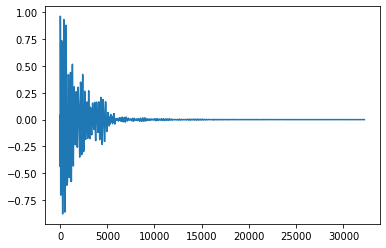

(2.892659127928326, (0.029944283960415815, 0.9158675411520918, 1.691977777855639, 0.03173027, 0.7596884071826935))


In [6]:
plt.plot(bad[len(bad)-1])
plt.show()

print(compute_quals(bad[len(bad)-1],w))

In [7]:
good_quals = []
for f in full:
    _, qs = compute_quals(f)
    good_quals.append(qs)

In [8]:
from contextlib import contextmanager

@contextmanager
def pgfplot(s):
    old_ba = plt.get_backend()
    matplotlib.use('pgf')
    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=plt.rcParams['figure.figsize'])
    yield
    plt.savefig(s)
    matplotlib.use(old_ba)

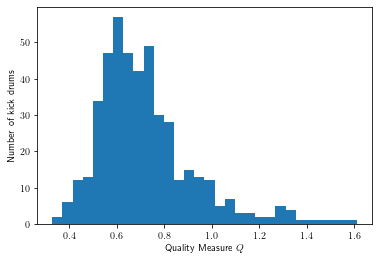

In [16]:
def add_quals(qs):
    return qs[0] * w[0] + qs[1] * w[1] + qs[2] * w[2] + qs[3] * w[3] + qs[4] * w[4]

full_quals = list(map(add_quals, good_quals))

# with pgfplot('qhist.pgf'):
plt.rcParams["hist.bins"] = 30
plt.hist(full_quals)
plt.xlabel('Quality Measure $Q$')
plt.ylabel('Number of kick drums')
plt.show()

In [10]:
for i in range(0,len(full_quals)):
    if(full_quals[i] > 1.4):
        print(os.listdir('../sampleset/full')[i], full_quals[i])

spectra_kick_oneshot_cained_E.wav 1.5164327974620693
spectra_kick_oneshot_deliver_C.wav 1.6095017025766492
spectra_kick_oneshot_pluckily_C#.wav 1.418766865514162
spectra_kick_oneshot_semiconducting_F#.wav 1.4687297984283492
wa_evolve_kick_05.wav 1.5283313238945775


In [15]:
print(np.mean(full_quals))
print(np.min(full_quals))
print(np.max(full_quals))

0.7203038170263909
0.3290237899082387
1.6095017025766492


spectra_kick_oneshot_awakener_G.wav
(0.07620141012611552, 0.24884962432255273, 0, 0.0009063897, 0.6282558441162109)
1.2023796148251553


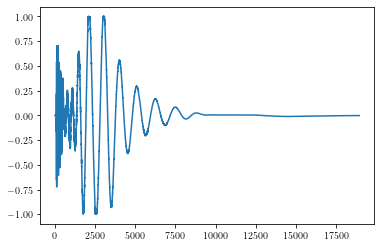

spectra_kick_oneshot_bilateral_F.wav
(0.004814115914195568, 0.4795589015425623, 0.6715972440075746, 7.831832e-05, 0.5687817633152008)
1.244065372219307


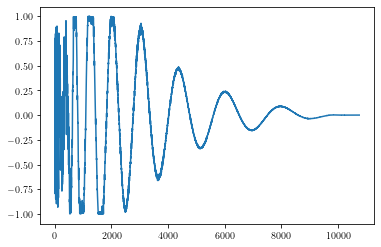

spectra_kick_oneshot_bottleOpener.wav
(0.09058246698125758, 0.29118646518431635, 0, 0.0039225626, 0.5347145795822144)
1.3266203173569524


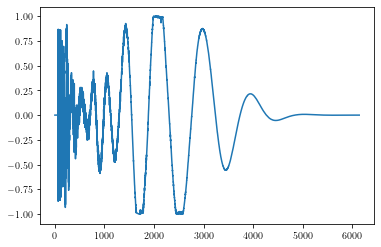

spectra_kick_oneshot_cained_E.wav
(0.01656824528102053, 0.42559483038408796, 0.868421618691022, 0.00041299372, 0.5374106466770172)
1.5164327974620693


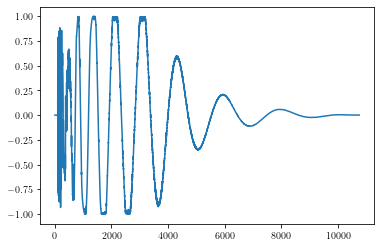

spectra_kick_oneshot_crowed_D#.wav
(0.012713749717373546, 0.41264915280983006, 0.6767184420327097, 0.0001366065, 0.661344438791275)
1.3411259480012137


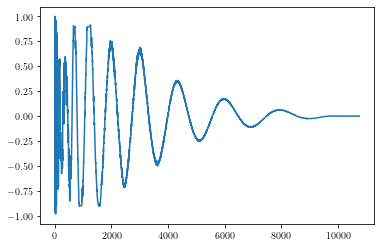

spectra_kick_oneshot_deliver_C.wav
(0.012243606542940655, 0.42157608084775794, 0.9842651790343979, 0.0006792294, 0.5813079178333282)
1.6095017025766492


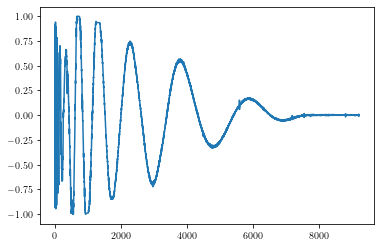

spectra_kick_oneshot_jawing_G.wav
(0.010480635185582347, 0.41091623461632104, 0.6703761092464141, 0.00017035747, 0.6454542577266693)
1.3037084222080146


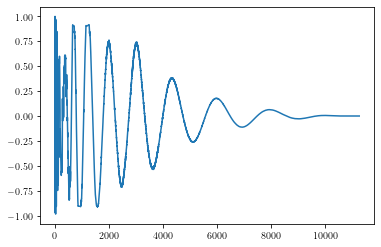

spectra_kick_oneshot_pluckily_C#.wav
(0.03408001316435682, 0.46451640402477173, 0.5761348618466122, 9.7056916e-05, 0.5387591123580933)
1.418766865514162


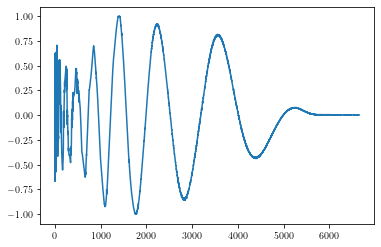

spectra_kick_oneshot_re20_A.wav
(0.016368394608378422, 0.5584166702532345, 0.5495514478788136, 0.004565369, 0.56492018699646)
1.2840345603317167


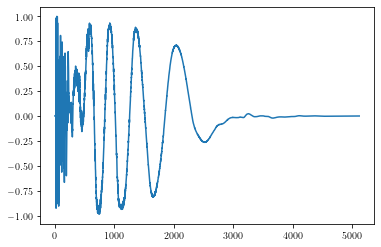

spectra_kick_oneshot_selfAbsorbed_D#.wav
(0.014346186660248532, 0.35730318078479634, 0.6799322421327876, 0.0032063718, 0.40456825494766235)
1.2107425701922745


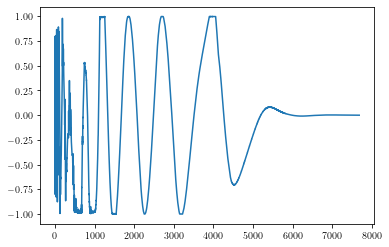

spectra_kick_oneshot_semiconducting_F#.wav
(0.021537335088651216, 0.44404175673516555, 0.713825911339947, 0.00010763441, 0.6345887780189514)
1.4687297984283492


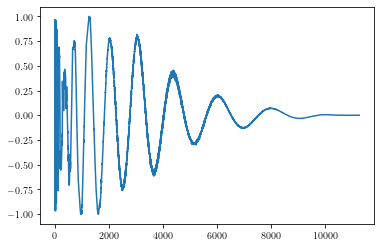

spectra_kick_oneshot_shriek_C#.wav
(0.016705198160035118, 0.41805459327212907, 0.6910038184399632, 0.00010319759, 0.47474205493927)
1.3046605193293546


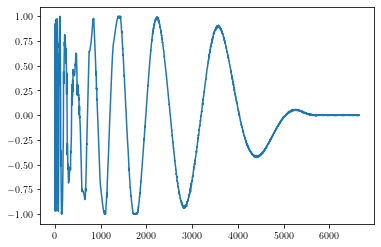

THT_Kicks_18.wav
(0.015289272495215644, 0.49168926452133516, 0.5111519880180444, 0.012115551, 0.6055517494678497)
1.236896322282365


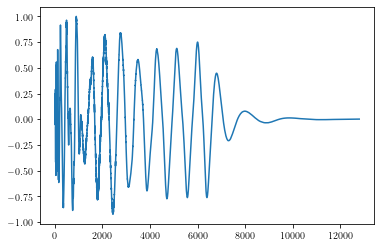

wa_evolve_kick_05.wav
(0.026927360659743903, 0.7980896839740675, 0.5368722885837371, 0.0032815165, 0.633155107498169)
1.5283313238945775


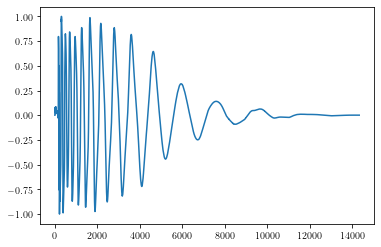

wa_evolve_kick_128.wav
(0.005759129662347476, 0.44818726956966803, 0.692760352398065, 0.019557558, 0.5403808057308197)
1.283750802671959


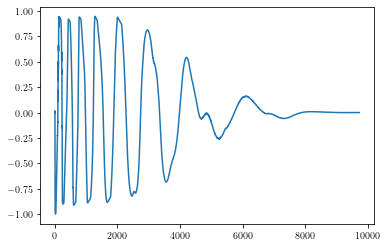

WDH_KICK008.wav
(0.018083920970689258, 0.7118501367761059, 0.44192790386917247, 0.0067455107, 0.6256028711795807)
1.3049846390231439


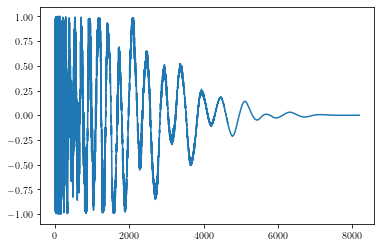

WDH_KICK010.wav
(0.010906920323269838, 1.2488256851203472, 0.2880907985704604, 0.0005330767, 0.5889692902565002)
1.3171236428949542


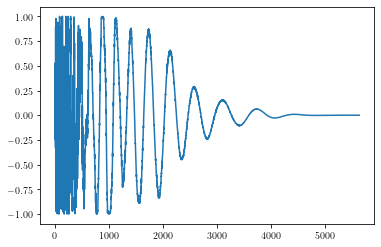

WDH_KICK031.wav
(0.0020418414596789763, 0.9185488250015513, 0.6012640270969792, 0.000977807, 0.5192530453205109)
1.3425389908143808


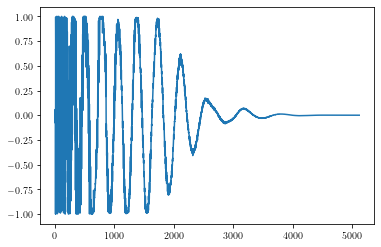

WDH_KICK073.wav
(0.005980850080755104, 0.9097930096531012, 0.593925312217522, 0.0024939235, 0.5222814381122589)
1.374758883967718


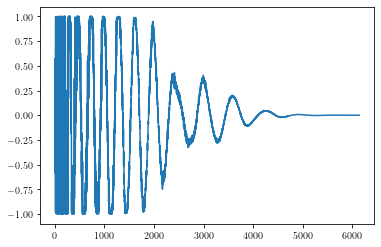

In [12]:
js = []
for j in range(0,len(full_quals)):
    if full_quals[j] > 1.2:
        js.append(j)
for j in js:
    print(os.listdir('../sampleset/full')[j])
    print(good_quals[j])
    print(full_quals[j])
    plt.plot(normalize(trim(full[j], top_db=50)[0]))
    plt.show()

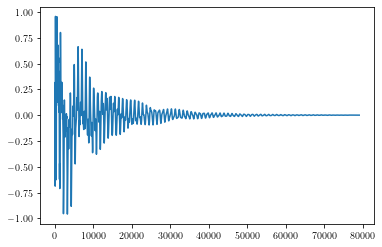

1.8016918638183532 (0.027142045257620866, 0.875817984942709, 0, 0.3375847, 0.834386020898819)


In [13]:
hyper = load("../sampleset/bad/Collider Sub Kick 01.wav")
plt.plot(hyper)
plt.show()

q, qs = compute_quals(hyper,w)
print(q, qs)

In [14]:
with open("quality/test.pkl", "rb") as f:
    result = pkl.load(f)

def order(x):
    y = x[0].split('/')
    n = y[len(y)-1]
    return int(n)

def val(x):
    return x[1]

result.sort(key=order)

plt.plot(range(0,400), list(map(val, result)))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'quality/test.pkl'

In [ ]:
print(result[10])

In [ ]:
from scipy.signal import butter,lfilter,sosfilt

def butter_hp(data, cutoff, fs=44100, order=4):
    """Simple Butterworth lowpass filter"""
    ncut = 2 * cutoff / fs
    sos = butter(order, ncut, btype='hp', analog = False, output='sos')
    y = sosfilt(sos, data)
    return y

tst1 = normalize(load('../results/wavegan/20210309222221/1/1.wav'))
tst1 = butter_hp(tst1, 10, order=4)
plt.plot(tst1)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit, least_squares

from quality.utils import moving_avg, butter_lp

def sigmoid(x, L, x0, k):
    """Sigmoid curve definition"""
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

def ls_func(popt, x, y):
    """Function for least squares to minimize"""
    l = sigmoid(x, *popt)
    return (l - y)

def env_fit(sample, lp=True, fev=10000, save_fig=None):
    """Find converging least squares fit, or return 0."""
    if lp:
        mv = butter_lp(sample, 1000)
    else:
        mv = moving_avg(np.abs(sample), 8)
    #find peaks
    xpeaks, _ = find_peaks(mv, width=64, height=1e-2)
    ypeaks = np.abs(mv[xpeaks])
    #fit curve
    p0 = [max(ypeaks), np.median(xpeaks),-.001]
    lbounds = [0, -np.inf, -5]
    ubounds = [1e05, len(sample), 0]
    if lp:
        fit_start = 0
    else:
        fit_start = np.argmax(ypeaks[0:6])
    try:
        popt, pcov = curve_fit(sigmoid, xpeaks[fit_start:], ypeaks[fit_start:], p0, method='dogbox', maxfev=fev, bounds=(lbounds,ubounds))
    except:
        return 0
    #save a figure of the fit
    if not save_fig is None:
        x = range(0, len(sample))
        plt.plot(mv)
        plt.plot(xpeaks, mv[xpeaks], "x")
        plt.plot(x, sigmoid(x, *popt))
        plt.show()
    #compute mean squared error
    l = sigmoid(xpeaks[fit_start:], *popt)
    return np.mean(np.square(l - ypeaks[fit_start:]))

In [ ]:
tst1 = trim(tst1, top_db=48)[0]

print(env_fit(tst1, fev=10000, save_fig="hi"))

def rms(sample):
    return np.sqrt(np.mean(sample**2))

print(rms(tst1))
print(frq_qual(tst1))
print(res_qual(tst1))
print(ihd_qual(tst1))